# EDA

In [100]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import pandas as pd
from tqdm.notebook import tqdm


from sentence_transformers import SentenceTransformer

pd.set_option('display.max_colwidth', None)

### Loading data

In [ ]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

In [ ]:
!kaggle datasets download -d jatinchawda/job-titles-and-description

Dataset URL: https://www.kaggle.com/datasets/jatinchawda/job-titles-and-description
License(s): unknown
100% 1.70G/1.71G [00:25<00:00, 169MB/s]
100% 1.71G/1.71G [00:25<00:00, 72.5MB/s]


In [ ]:
! unzip "job-titles-and-description.zip"

Archive:  job-titles-and-description.zip
  inflating: clean_data.parquet      


### Looking at data

In [ ]:
df = pd.read_parquet('clean_data.parquet')
df.head()

,job_title,job_desc
0,Computer Science Data Mining Engineering Machine Learning Mathematics Model deployment +7,Career development Startup environment
1,Agile AWS Azure Computer Science CX Engineering +7,Career development Startup environment
2,"Consulting Director, Machine Learning/Computer Vision",AWS Azure Classification Computer Science Computer Vision Consulting +10
3,Full Stack Developer (AI),Angular Computer Science JavaScript Keras MongoDB NoSQL +6
4,"Senior Principal Analyst, Artificial Intelligence (AI)",Consulting Excel Market research Research Spark


In [ ]:
df.describe()

,job_title,job_desc
count,1415532,1415417
unique,921194,1369336
top,Data Analyst,"Your time. Your Goals. What is DoorDash Available in over 4,000 cities in the U.S, DoorDash connects local businesses and local drivers (called Dashers) with opportunities to earn, work, and live. As a Dasher, you can be your own boss and enjoy the flexibility of choosing when, where, and how much you earn. All you need is a mode of transportation (bike, car, scooter) and a smartphone to start making money. It s that simple. You can even sign up and begin working that same day. With Dasher Direct, you can also get paid the same day! Why deliver with DoorDash Choose your own hours: When and where you work is totally up to you. Freedom to dash anywhere: Deliver near your home or in a city you're just visiting. Easy to get started: Don't worry about car inspections or vehicle restrictions. Just sign up and receive everything you need to start earning. Receive deliveries right away: Once approved, log on to the Dasher app to receive nearby orders immediately. Know how much you'll make: Clear and concise pay model lets you know the minimum amount you will make before accepting any order Don t wait for pay: Get paid the same day you dash, automatically and with no deposit fee - ever. Earn extra money for your goals: Achieve your short-term goals or long-term dreams by driving or biking with DoorDash. Sign Up Details Requirements 18 or older Any car, scooter, or bicycle (in select cities) Driver's license number Social security number (only in the US) Final Step: consent to a background check How to sign up Click Apply Now and complete the sign up Get the app and go"
freq,3487,1350


---

!!! We have 2 columns, but task mentions only *job_title*. So lets remove *job_desc*.

In [ ]:
df = df.drop('job_desc', axis=1)
df.to_parquet('job_titles.parquet')

In [ ]:
df.head()

,job_title
0,Computer Science Data Mining Engineering Machine Learning Mathematics Model deployment +7
1,Agile AWS Azure Computer Science CX Engineering +7
2,"Consulting Director, Machine Learning/Computer Vision"
3,Full Stack Developer (AI)
4,"Senior Principal Analyst, Artificial Intelligence (AI)"


In [ ]:
df.job_title.value_counts()[:7]

,count
job_title,
Data Analyst,3487
Data Scientist,1696
Data Engineer,1442
Senior Data Analyst,920
Business Analyst,855
Software Development Engineer,573
Senior Data Engineer,456


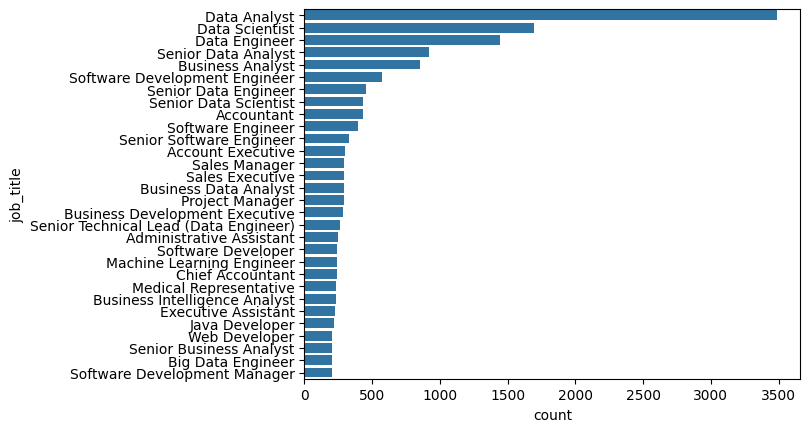

In [ ]:
sns.barplot(df.job_title.value_counts()[:30], orient='h');

### Some Preprocessing

In [ ]:
df.job_title.isna().sum()

1

In [ ]:
df = df.dropna()

---

We want to speed up. So let's get a sample from data. We don't need 1.5M titles for now.

---

In [ ]:
df.sample(10 ** 4, random_state=19).to_parquet('job_titles_sample.parquet')
df = pd.read_parquet('job_titles_sample.parquet')
print(df.shape)
df.head()

(10000, 1)


,job_title
798805,Communications and Engagement Specialist
734992,Senior Account Manager (Security Systems Integration)
798502,"Sales Development Representative, BytePlus"
1006106,Java Software Developer/ Java Programmer/ $7K++ /Good Bonus
463008,COBOL Programmer (100% Remote)


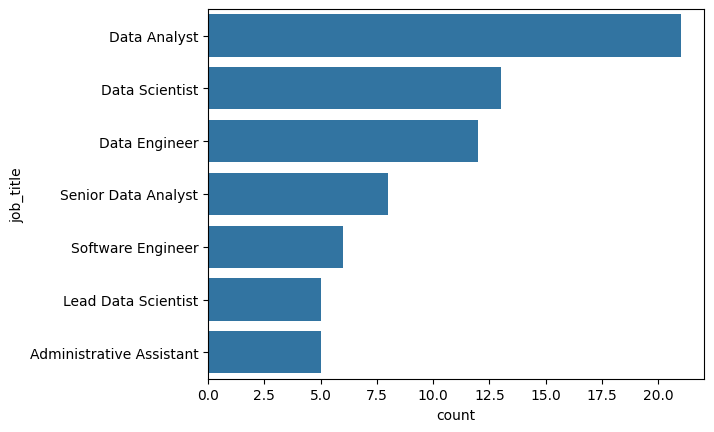

In [ ]:
# check distribution of popular jobs
sns.barplot(df.job_title.value_counts()[:7], orient='h');

In [ ]:
df[df.job_title.str.contains(',')].head(10)

,job_title
798502,"Sales Development Representative, BytePlus"
47953,"2023, EMEA, Treasury and Trade Solutions Summer Analyst, Summer Internship..."
726240,"Writer, Iraq News"
261724,"Fullstack Web developer internship: .NET, Angular"
751828,"Area Manager East Anglia, £30,000 plus company car"
953727,"Senior Payroll Specialist | BAU, Compliance and System Integration | $110-$120k"
300110,"Registered Nurse II (RN) Cardiology Days- $15,000 Sign-On and Referral Bonus - Houston Methodist Hospital"
665955,"Quality Analyst III, Microbiology"
400470,"CHE752021 - Director of Nursing 4, Assistant (Quality, Safety and Service Improvement Team)"
672733,"Get Started in Logistics - We offer benefits and $1,000+ in Bonuses!"


Maybe it's not such a good idea to remove punctuation
so for now it's an option.

In [ ]:
def preprocess_text(text, remove_punctuation=False):
    text = text.lower()
    # removing puctuation
    if remove_punctuation:
        text = re.sub(r'[\W_]+', ' ', text)
        text = re.sub(r'\s+', ' ', text).strip()
    return text

In [ ]:
df['job_title_lowered'] = df['job_title'].apply(preprocess_text)

In [ ]:
df.to_parquet('sample_job_titles_preprocessed.parquet')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df.to_parquet('/content/drive/MyDrive/Data/sample_job_titles_preprocessed.parquet')

# Task 1. Features & Embeddings

In [ ]:
df = pd.read_parquet('/content/drive/MyDrive/Data/sample_job_titles_preprocessed.parquet')
print(df.shape)
df.head()

(10000, 2)


,job_title,job_title_lowered
798805,Communications and Engagement Specialist,communications and engagement specialist
734992,Senior Account Manager (Security Systems Integration),senior account manager (security systems integration)
798502,"Sales Development Representative, BytePlus","sales development representative, byteplus"
1006106,Java Software Developer/ Java Programmer/ $7K++ /Good Bonus,java software developer/ java programmer/ $7k++ /good bonus
463008,COBOL Programmer (100% Remote),cobol programmer (100% remote)


### NLTK for job titles, Stanford NER (unsuccessful)

In [ ]:
!pip install svgling

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 3.4 MB/s eta 0:00:00


In [ ]:
import nltk
from nltk.tag import StanfordNERTagger
from nltk import word_tokenize, pos_tag, ne_chunk

nltk.download('punkt')
nltk.download('punkt_tab')

nltk.download('maxent_ne_chunker')
nltk.download('maxent_ne_chunker_tab')
nltk.download('words')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker_tab to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker_tab is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [ ]:
!wget 'https://nlp.stanford.edu/software/stanford-ner-2018-10-16.zip'
!unzip stanford-ner-2018-10-16.zip

--2025-03-05 08:11:50--  https://nlp.stanford.edu/software/stanford-ner-2018-10-16.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://downloads.cs.stanford.edu/nlp/software/stanford-ner-2018-10-16.zip [following]
--2025-03-05 08:11:51--  https://downloads.cs.stanford.edu/nlp/software/stanford-ner-2018-10-16.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 180358328 (172M) [application/zip]
Saving to: ‘stanford-ner-2018-10-16.zip’

stanford-ner-2018-1 100%[===================>] 172.00M  3.90MB/s    in 31s     

2025-03-05 08:12:22 (5.49 MB/s) - ‘stanford-ner-2018-10-16.zip’ saved [180358328/180358328]



In [ ]:
jar_path = 'stanford-ner-2018-10-16/stanford-ner.jar'
st = StanfordNERTagger('/content/stanford-ner-2018-10-16/classifiers/english.muc.7class.distsim.crf.ser.gz',
                       jar_path,
                        encoding='utf-8'
                       )
st.tag('Senior Sales Manager - Multi Country Solutions - Sweden (Remote Based...'.split())

[('Senior', 'O'),
 ('Sales', 'O'),
 ('Manager', 'O'),
 ('-', 'O'),
 ('Multi', 'ORGANIZATION'),
 ('Country', 'ORGANIZATION'),
 ('Solutions', 'ORGANIZATION'),
 ('-', 'O'),
 ('Sweden', 'LOCATION'),
 ('(Remote', 'O'),
 ('Based...', 'O')]

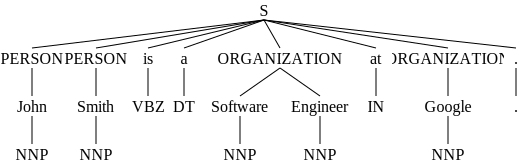

In [ ]:
tokens = word_tokenize('John Smith is a Software Engineer at Google.')
pos_tags = pos_tag(tokens)
pos_tags
named_entities = ne_chunk(pos_tags)
named_entities

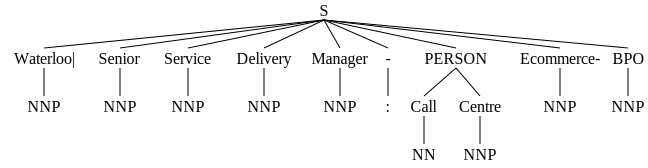

In [ ]:
tokens = word_tokenize('Waterloo| Senior Service Delivery Manager - Call Centre Ecommerce- BPO')
pos_tags = pos_tag(tokens)
pos_tags
named_entities = ne_chunk(pos_tags)
named_entities

#### Does not look good. I haven't found convenient way to use in python Stanford RegexNer which should be a little bit better. Let's try some NNs

### BERT model for Job Titles

In [ ]:
from transformers import pipeline
from transformers import AutoTokenizer, AutoModel

Found this model for job titles: https://huggingface.co/itsmeboris/jobbert-base-cased-ner

Readme says that:
* Job Title precision: 0.7916
* Job Title recall: 0.8721
* **Job Title f1: 0.8299**

And that's nice

In [ ]:
ner_bert = pipeline(model="itsmeboris/jobbert-base-cased-ner")

Device set to use cpu


In [ ]:
for i in range(20):
    print(df.job_title.values[i])

Communications and Engagement Specialist
Senior Account Manager (Security Systems Integration)
Sales Development Representative, BytePlus
Java Software Developer/ Java Programmer/ $7K++ /Good Bonus
COBOL Programmer (100% Remote)
2023, EMEA, Treasury and Trade Solutions Summer Analyst, Summer Internship...
Senior Sales Manager - Multi Country Solutions - Sweden (Remote Based...
Sonographer I
Writer, Iraq News
Fullstack Web developer internship: .NET, Angular
Marketing Program Manager II
D365 Core Financials Business Analyst | Remote
Senior Digital Analyst - Fully Remote Working
Field Service Engineer - Bristol area
Waterloo| Senior Service Delivery Manager - Call Centre Ecommerce- BPO
Area Manager East Anglia, £30,000 plus company car
Senior Payroll Specialist | BAU, Compliance and System Integration | $110-$120k
Quantitative Research Analyst Internship
Network PM Co-Ordinator
Registered Nurse II (RN) Cardiology Days- $15,000 Sign-On and Referral Bonus - Houston Methodist Hospital


In [ ]:
ner_bert('Senior Account Manager (Security Systems Integration)')

[{'entity': 'B-JOB_TITLE',
  'score': 0.95268804,
  'index': 1,
  'word': 'Senior',
  'start': 0,
  'end': 6},
 {'entity': 'B-JOB_TITLE',
  'score': 0.9764213,
  'index': 2,
  'word': 'A',
  'start': 7,
  'end': 8},
 {'entity': 'B-JOB_TITLE',
  'score': 0.96927917,
  'index': 3,
  'word': '##cco',
  'start': 8,
  'end': 11},
 {'entity': 'B-JOB_TITLE',
  'score': 0.96673954,
  'index': 4,
  'word': '##unt',
  'start': 11,
  'end': 14},
 {'entity': 'B-JOB_TITLE',
  'score': 0.97306406,
  'index': 5,
  'word': 'Manager',
  'start': 15,
  'end': 22},
 {'entity': 'B-ORG',
  'score': 0.38778576,
  'index': 7,
  'word': 'Security',
  'start': 24,
  'end': 32},
 {'entity': 'B-ORG',
  'score': 0.3822656,
  'index': 8,
  'word': 'Systems',
  'start': 33,
  'end': 40},
 {'entity': 'B-ORG',
  'score': 0.38039348,
  'index': 9,
  'word': 'Integration',
  'start': 41,
  'end': 52}]

In [ ]:
ner_bert('Waterloo| Senior Service Delivery Manager - Call Centre Ecommerce- BPO')

[{'entity': 'B-LOC',
  'score': 0.9113091,
  'index': 1,
  'word': 'Waterloo',
  'start': 0,
  'end': 8},
 {'entity': 'B-JOB_TITLE',
  'score': 0.9273898,
  'index': 3,
  'word': 'Senior',
  'start': 10,
  'end': 16},
 {'entity': 'B-JOB_TITLE',
  'score': 0.9718198,
  'index': 4,
  'word': 'Service',
  'start': 17,
  'end': 24},
 {'entity': 'B-JOB_TITLE',
  'score': 0.97387856,
  'index': 5,
  'word': 'Del',
  'start': 25,
  'end': 28},
 {'entity': 'B-JOB_TITLE',
  'score': 0.9575114,
  'index': 6,
  'word': '##iver',
  'start': 28,
  'end': 32},
 {'entity': 'B-JOB_TITLE',
  'score': 0.95920265,
  'index': 7,
  'word': '##y',
  'start': 32,
  'end': 33},
 {'entity': 'B-JOB_TITLE',
  'score': 0.97609586,
  'index': 8,
  'word': 'Manager',
  'start': 34,
  'end': 41},
 {'entity': 'B-JOB_TITLE',
  'score': 0.78535306,
  'index': 10,
  'word': 'Call',
  'start': 44,
  'end': 48},
 {'entity': 'B-JOB_TITLE',
  'score': 0.76221657,
  'index': 11,
  'word': 'Centre',
  'start': 49,
  'end': 55

#### That looks much more promising

In [ ]:
def extract_job_title(ner_results):
    job_title_tokens = []
    for entity in ner_results:
        if entity['entity'].startswith('B-JOB_TITLE'):
            word = entity['word']
            job_title_tokens.append(word)

    return (' '.join(job_title_tokens)).replace(' ##', '')

In [ ]:
extract_job_title(ner_bert('Senior Account Manager (Security Systems Integration)'))

'Senior Account Manager'

In [ ]:
df['bert_title'] = df.apply(lambda x: extract_job_title(ner_bert(x['job_title'])), axis=1)
df.head(20)

,job_title,job_title_lowered,bert_title
798805,Communications and Engagement Specialist,communications and engagement specialist,Communications and Engagement Specialist
734992,Senior Account Manager (Security Systems Integration),senior account manager (security systems integration),Senior Account Manager
798502,"Sales Development Representative, BytePlus","sales development representative, byteplus",Sales Development Representative
1006106,Java Software Developer/ Java Programmer/ $7K++ /Good Bonus,java software developer/ java programmer/ $7k++ /good bonus,Java Software Developer Java Programmer
463008,COBOL Programmer (100% Remote),cobol programmer (100% remote),##BOL Programmer
47953,"2023, EMEA, Treasury and Trade Solutions Summer Analyst, Summer Internship...","2023, emea, treasury and trade solutions summer analyst, summer internship...",##MEA Summer Analyst Interns
46274,Senior Sales Manager - Multi Country Solutions - Sweden (Remote Based...,senior sales manager - multi country solutions - sweden (remote based...,Senior Sales Manager
300927,Sonographer I,sonographer i,
726240,"Writer, Iraq News","writer, iraq news",Writer
261724,"Fullstack Web developer internship: .NET, Angular","fullstack web developer internship: .net, angular",Fullstack Web developer


In [ ]:
df[['job_title', 'bert_title']].head(50)

,job_title,bert_title
798805,Communications and Engagement Specialist,Communications and Engagement Specialist
734992,Senior Account Manager (Security Systems Integration),Senior Account Manager
798502,"Sales Development Representative, BytePlus",Sales Development Representative
1006106,Java Software Developer/ Java Programmer/ $7K++ /Good Bonus,Java Software Developer Java Programmer
463008,COBOL Programmer (100% Remote),##BOL Programmer
47953,"2023, EMEA, Treasury and Trade Solutions Summer Analyst, Summer Internship...",##MEA Summer Analyst Interns
46274,Senior Sales Manager - Multi Country Solutions - Sweden (Remote Based...,Senior Sales Manager
300927,Sonographer I,
726240,"Writer, Iraq News",Writer
261724,"Fullstack Web developer internship: .NET, Angular",Fullstack Web developer


In [ ]:
# I don't need this for now
df = df.drop('job_title_lowered', axis=1)

In [ ]:
df.to_parquet('/content/drive/MyDrive/Data/sample_job_bert_titles.parquet')

### Data check for BERT titles

In [ ]:
df.bert_title.value_counts()

,count
bert_title,
,327
Data Analyst,36
Senior Care Provider,33
Software Engineer,22
Project Manager,21
...,...
Manager Field SalesFW,1
Head of Loan Documentation & Security,1
Boilermaker Supervisor,1


In [ ]:
df[df.bert_title == ''].sample(15)

,job_title,bert_title
974552,Storeperson,
379471,Maintenance and Close / Open,
986650,CHEF,
171218,2021 Grain Harvest Workers,
1298901,Marketing Positions,
1291276,Festival Bar Staff,
1372267,Google Sheets + Data Studio Build using Supermetrics,
332058,Cafe Staff,
963677,Sub Agent,
109327,Skilled Butcher,


In [ ]:
df[df.bert_title.str.contains('CTO')]

,job_title,bert_title
999324,REGIONAL DIRECTOR OF OPERATIONS,REGIONAL DIRECTOR
1228039,"INSTRUCTOR, VOCATIONAL",##STRUCTORATIONAL
1074652,"DIRECTOR/RESEARCH, EVALUATION &amp; COMMUNICATION",##IRECTORESEARCHVALUAT
1221075,"DIRECTOR OF DINING SERVICES II- Jamaica Plain, MA",DIRECTOR D SERVICES
971655,ASSISTANT DIRECTOR OF CURRICULUM &amp; ASSESSMENT,ASSISTANT DIRECTOR OF CURRICULUMSESSMENT
522649,NUCLEAR TECHNICAL DIRECTOR,NUCLEAR TECHNICAL DIRECTOR
1164388,DIRECTOR OF KUMMER STU PRGMS #00079242,DIRECTOR OF KUMMERU
457728,CTO / Chief Technical Officer - Co-founder,CTO Chief Technical Officer
404264,"FACILITY DIRECTOR - BENCH - Syracuse, NY",FACILITY DIRECTOR BENCH
1016305,SENIOR DIRECTOR OPERATIONS AMBULATORY,SENIOR DIRECTOR OATIONBULATORY


In [ ]:
df[df.bert_title.str.contains('CFO')]

,job_title,bert_title


In [ ]:
df[df.bert_title.str.contains('CEO')]

,job_title,bert_title
922531,Managing Partner/ CEO (f/m/d),Managing Partner CEO


In [ ]:
df[df.bert_title.str.contains('Chief')]

,job_title,bert_title
502132,Automation Integration Bureau Chief - Division of Welfare,Automation Integration Bureau Chief
472329,Chief Operating Officer,Chief Operating Officer
721137,Chief Operations Officer,Chief Operations Officer
866696,"Deputy Chief Dealer, Foreign Exchange",Deputy Chief Dealer
1313229,Deputy Chief Executive Officer,Deputy Chief Executive Officer
457728,CTO / Chief Technical Officer - Co-founder,CTO Chief Technical Officer
805565,"VP, AML Chief of Staff Officer",VP AML Chief of Staff Officer
1144357,NASA Info Architect Chief,NASA Info Architect Chief
689497,Chief Accountant - Praha Karlín,Chief Accountantraha
424880,SAES2 Chief Operating Officer,Chief Operating Officer


In [ ]:
df[df.bert_title.str.contains('VP') | df.bert_title.str.contains('Vice')]

,job_title,bert_title
865463,"Area Vice President, Commercial Sales",Area Vice President Commercial Sales
102645,"Regional Vice President Sales, Service Cloud",Regional Vice President Sales
117869,VP Product Management Ad Platforms,VP Product Management
1355799,"Vice President - Technology & Disruptive Commerce, Middle Market Banking & Specialized Industries, Relationship Manager",Vice President Technology & Disruptive Commerce Relationship Manager
183487,Investment Product Senior Risk Manager - Vice President,Investment Product Senior Risk Manager Vice President
...,...,...
276520,Corporate Credit Risk Specialist - Loans & Derivatives (Associate/Vice President),Corporate Credit Risk Specialist Loans & Derivatives Associate Vice President
521344,"VP, Portfolio Manager - Middle Market C&I Lending",VP Portfolio Manager
459892,VP Of Marketing - Remote,VP Of Marketing
455650,"Vice President, Banking",Vice President Banking


In [ ]:
df[df.bert_title.str.contains('Owner')]

,job_title,bert_title
330339,Product Owner - Home based - UK wide,Product Owner
240044,Relationship Manager and Business Owner Specialist - Limestone Shopping Center Financial Center - Delaware Market - Wilmington/D,Relationship Manager and Business Owner Specialist
713610,ClearReview Product Owner,Product Owner
554298,Product Owner - Mobile App,Product Owner
1355744,Software Engineering - Backlog Owner - BO / PM / Jira,Software Engineering Backlog OwnerOra
865026,R&amp;D Technical Product Owner,D Technical Product Owner
1188164,CDL Class A Truck Driver - Owner Operator - Regional & Dedicated Lanes,CDL Class A Truck Driver Owner Operator
1200293,"Product Owner Agile, SaaS - FULLY REMOTE! Up to £55k",Product Owner A
86680,Product Owner-Microsoft Dynamics 365 CRM,Product Owner
1336865,Adobe Product Owner,Adobe Product Owner


In [ ]:
df[df.bert_title.str.contains('Assistant')]

,job_title,bert_title
400470,"CHE752021 - Director of Nursing 4, Assistant (Quality, Safety and Service Improvement Team)",Director of Nursing Assistant
934555,Teaching Assistant EYFS - Full-time,Teaching AssistantYFS
791157,Optical Assistant - Reading - Fashionable Independent,Optical Assistant
1259345,Assistant Public Relations Officer,Assistant Public Relations Officer
894693,Assistant Director of Nursing/QA Nurse,Assistant Director of Nursing / QA Nurse
...,...,...
425433,Administration Assistant/Customer Service,Administration Assistant Customer Service
1164512,Sr Assistant-Medical Lab Phlebotomist-PRN,Sr Assistant Medical Lab PhlebotomistN
72164,Senior Programme Assistant,Senior Programme Assistant
585045,PMLD Teaching Assistant,##LD Teaching Assistant


### Get embeddings

In [ ]:
for i in df.head(20).values:
    print(i[0])

Communications and Engagement Specialist
Senior Account Manager (Security Systems Integration)
Sales Development Representative, BytePlus
Java Software Developer/ Java Programmer/ $7K++ /Good Bonus
COBOL Programmer (100% Remote)
2023, EMEA, Treasury and Trade Solutions Summer Analyst, Summer Internship...
Senior Sales Manager - Multi Country Solutions - Sweden (Remote Based...
Sonographer I
Writer, Iraq News
Fullstack Web developer internship: .NET, Angular
Marketing Program Manager II
D365 Core Financials Business Analyst | Remote
Senior Digital Analyst - Fully Remote Working
Field Service Engineer - Bristol area
Waterloo| Senior Service Delivery Manager - Call Centre Ecommerce- BPO
Area Manager East Anglia, £30,000 plus company car
Senior Payroll Specialist | BAU, Compliance and System Integration | $110-$120k
Quantitative Research Analyst Internship
Network PM Co-Ordinator
Registered Nurse II (RN) Cardiology Days- $15,000 Sign-On and Referral Bonus - Houston Methodist Hospital


#### Our data is unlabeled. We want to perform clustering for job areas. So let's use some model for feature extraction.
I took this model: https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2
It's universal and fast. And I don't have too many computational capacities

In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [ ]:
embeddings = model.encode(df.bert_title.values)
embeddings.shape

(10000, 384)

In [ ]:
np.save('/content/drive/MyDrive/Data/mini_lm_embeds_sample.npy', embeddings)

### Visualize

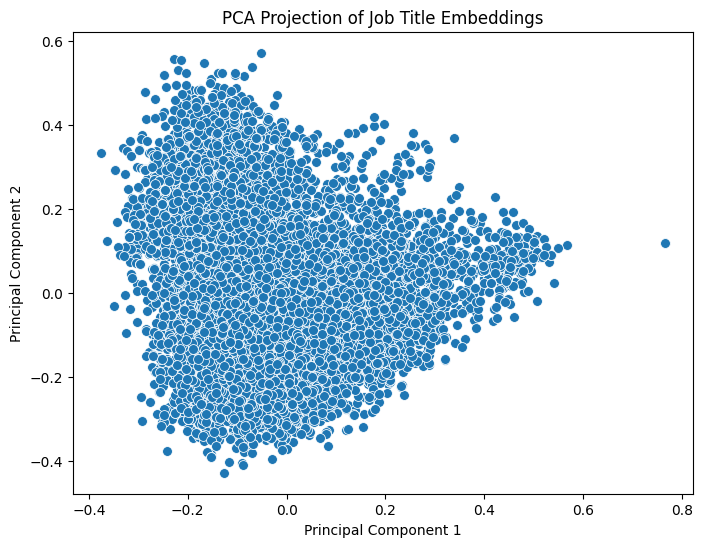

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Using PCA for initial dimensionality reduction
pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings)

plt.figure(figsize=(8,6))
sns.scatterplot(x=embeddings_pca[:,0], y=embeddings_pca[:,1], s=50)
plt.title('PCA Projection of Job Title Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

<ipython-input-116-5a57f9c85d69>:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=embeddings_tsne[:,0], y=embeddings_tsne[:,1], s=50, palette='viridis')


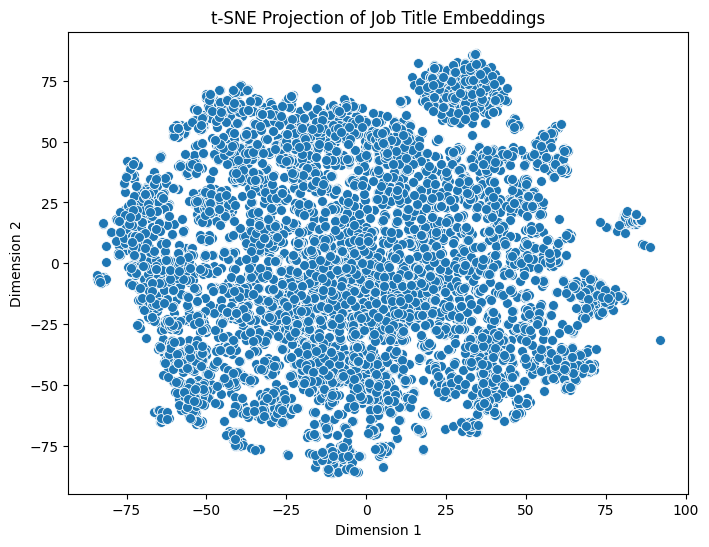

In [ ]:
# t-sne as more sophisticated approach
tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne = tsne.fit_transform(embeddings)

plt.figure(figsize=(8,6))
sns.scatterplot(x=embeddings_tsne[:,0], y=embeddings_tsne[:,1], s=50)
plt.title('t-SNE Projection of Job Title Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

It seems like t-SNE can split data into clusters. But without any labels it's hard to say how good are embeddings.  
We will look at it later.

# Task 2. Algorithms to extract jobs info

We have 2 classification problems:
* job level
* job area by NAICS

## Job Level Classification problem


### Qwen2.5 + BERT for feature creation

Let's create weak labels with generative models. With limits of free google colab I consider small version under 3B parameters.

In [ ]:
df = pd.read_parquet('/content/drive/MyDrive/Data/sample_job_bert_titles.parquet')
df.head()

,job_title,bert_title
798805,Communications and Engagement Specialist,Communications and Engagement Specialist
734992,Senior Account Manager (Security Systems Integration),Senior Account Manager
798502,"Sales Development Representative, BytePlus",Sales Development Representative
1006106,Java Software Developer/ Java Programmer/ $7K++ /Good Bonus,Java Software Developer Java Programmer
463008,COBOL Programmer (100% Remote),##BOL Programmer


In [5]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import pandas as pd
from tqdm.notebook import tqdm

model_name = "Qwen/Qwen2.5-3B-Instruct"

# Load tokenizer and model. Using float16 for faster inference on GPU.
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="auto",
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/7.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/661 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/35.6k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

In [8]:
labels = [
    "Student/Intern", "Junior", "Assistant", "Middle",
    "Senior", "Manager", "Director", "VP", "C-Level", "Founder/Owner",
    "Other"
]

def classify_job_title(job_title, verbose=False):
    prompt = (
        "You are an expert job title classifier. "
        "Your task is to choose exactly one category from the following list: "
        f"{', '.join(labels)}.\n\n"
        "Classify the following job title, and reply with only one of the above labels!!!\n"
        f"Job title: {job_title}\n\n"
        f"If there is no explicit clue, answer 'Other'\n"
        f"Choose wisely. What category describes job title better? Answer:"
    )
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    # Generate a short answer (max_new_tokens=10 is enough)
    output_ids = model.generate(**inputs, max_new_tokens=10,
                                do_sample=False,
                                temperature=None,
                                top_p=None,
                                top_k=None
                                )
    output_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    # Check if the output contains "Answer:" before attempting to split
    if "Answer:" in output_text:
        answer = output_text.split("Answer:")[-1].strip()
        # Further check if answer is not empty before splitting by spaces
        if answer:
            answer = answer.split()[0]
        else:
            answer = "Other" # If answer is empty, default to 'Other'
    else:
        # If "Answer:" is not found, default to 'Other'
        answer = "Other"

    if verbose:
        print(f"Prompt: {job_title}")
        print(f"Answer: {answer}")
        print('*' * 40)

    return answer



job_titles = df.sample(20, random_state=19).job_title.values


# df = pd.read_csv(".csv")
# job_titles = df["JobTitle"].tolist()

# Process each job title and store results
results = []
for title in tqdm(job_titles, desc="Classifying job titles"):
    level = classify_job_title(title)
    results.append((title, level))

# Create a DataFrame to display the results
df_results = pd.DataFrame(results, columns=["Job Title", "Predicted Level"])
df_results

Classifying job titles:   0%|          | 0/20 [00:00<?, ?it/s]

,Job Title,Predicted Level
0,Executive Assistant,Assistant
1,IT Service Desk Technician,Assistant
2,Carpentry Apprentice,Assistant
3,Sales Executive | Residential Projects,Junior
4,Utility Worker - Gas T&D (IBEW) Bakersfield,Other
5,Associate Producer (Temporary) (Lithonia),Assistant
6,"Specialist, Mobile Plumber",Other
7,Digital Marketing Coordinator - Auckland,Assistant
8,Plastic Injection Moulding Setter,Other
9,Technical Consultant,Technical


I would not say that Qwen is good here. But it shows some result.
Let's try to use it with cleaned version from bert model.

In [75]:
job_titles = df[:30].bert_title.values

job_titles = [ttl.replace('##', '') for ttl in job_titles]

results = []
for title in tqdm(job_titles, desc="Classifying job titles"):
    level = classify_job_title(title)
    results.append((title, level))

# Create a DataFrame to display the results
df_results = pd.DataFrame(results, columns=["Job Title", "Predicted Level"])
df_results

Classifying job titles:   0%|          | 0/30 [00:00<?, ?it/s]

,Job Title,Predicted Level
0,Communications and Engagement Specialist,Middle
1,Senior Account Manager,Senior
2,Sales Development Representative,Assistant
3,Java Software Developer Java Programmer,Junior
4,BOL Programmer,Other
5,MEA Summer Analyst Interns,Student/Intern
6,Senior Sales Manager,Senior
7,,Other
8,Writer,Other
9,Fullstack Web developer,Junior


Subjectively, it looks better.

Also interesting how model performs with rare CEO titles.

In [77]:
chief_df = df[df.job_title.str.contains('CEO') | df.job_title.str.contains('Chief')]
job_titles = chief_df.job_title.values

job_titles = [ttl.replace('##', '') for ttl in job_titles]

# df = pd.read_csv(".csv")
# job_titles = df["JobTitle"].tolist()

# Process each job title and store results
results = []
for title in tqdm(job_titles, desc="Classifying job titles"):
    level = classify_job_title(title)
    results.append((title, level))

# Create a DataFrame to display the results
df_results = pd.DataFrame(results, columns=["Job Title", "Predicted Level"])
df_results

Classifying job titles:   0%|          | 0/31 [00:00<?, ?it/s]

,Job Title,Predicted Level
0,Automation Integration Bureau Chief - Division of Welfare,Director
1,Chief Operating Officer,VP
2,Integration Manager and Executive Assistant to the CEO (m/f/d),Manager
3,Chief Operations Officer,VP
4,"Deputy Chief Dealer, Foreign Exchange",Other
5,Deputy Chief Executive Officer,Director
6,CTO / Chief Technical Officer - Co-founder,Founder/Owner
7,"VP, AML Chief of Staff Officer",VP
8,NASA Info Architect Chief,Director
9,Chief Accountant - Praha Karlín,C-Level


#### Qwen does not create very reliable labels. But we can create multiple, with BERT titles and without

#### Running for the whole sample

In [82]:
job_titles = df.job_title.values

results = []
for title in tqdm(job_titles, desc="Classifying job titles"):
    level = classify_job_title(title)
    results.append((title, level))

# Create a DataFrame to display the results
df['qwen_job_level'] = [res[1] for res in results]

df.to_parquet('/content/drive/MyDrive/Data/sample_job_qwen_titles.parquet')

Classifying job titles:   0%|          | 0/10000 [00:00<?, ?it/s]

In [3]:
df = pd.read_parquet('/content/drive/MyDrive/Data/sample_job_qwen_titles.parquet')


,job_title,bert_title,qwen_job_level
798805,Communications and Engagement Specialist,Communications and Engagement Specialist,Middle
734992,Senior Account Manager (Security Systems Integration),Senior Account Manager,Senior
798502,"Sales Development Representative, BytePlus",Sales Development Representative,Assistant
1006106,Java Software Developer/ Java Programmer/ $7K++ /Good Bonus,Java Software Developer Java Programmer,Java
463008,COBOL Programmer (100% Remote),##BOL Programmer,Other


In [9]:
### for BERT cleaned title
job_titles = df.bert_title.values

results = []
for title in tqdm(job_titles, desc="Classifying job titles"):
    level = classify_job_title(title)
    results.append((title, level))

# Create a DataFrame to display the results
df['qwen_bert_job_level'] = [res[1] for res in results]

df.to_parquet('/content/drive/MyDrive/Data/sample_job_qwen_bert_titles.parquet')

Classifying job titles:   0%|          | 0/10000 [00:00<?, ?it/s]

#### Preprocessing weak labels

Now we have weak labels from relatively fast and cheap model. We can use them as features after some preprocessing

In [3]:
df = pd.read_parquet('/content/drive/MyDrive/Data/sample_job_qwen_bert_titles.parquet')

In [9]:
df.qwen_job_level.value_counts()[:25]

,count
qwen_job_level,
Other,4153
Assistant,1242
Senior,1042
Manager,943
Junior,708
Middle,640
Director,372
Student/Intern,294
VP,73


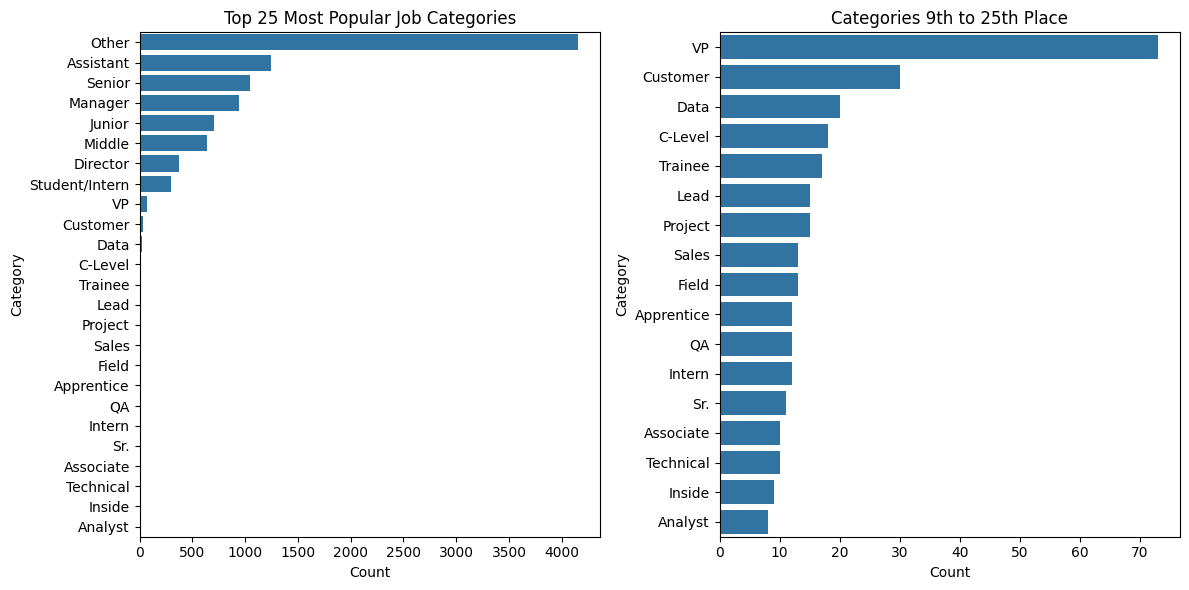

In [15]:
plt.figure(figsize=(12, 6))

# First subplot: Top 25 most popular categories
plt.subplot(1, 2, 1)
top_25_categories = df.qwen_job_level.value_counts()[:25]
sns.barplot(y=top_25_categories.index, x=top_25_categories.values, orient='h')
plt.title('Top 25 Most Popular Job Categories')
plt.xlabel('Count')
plt.ylabel('Category')


# Second subplot: Categories from 9th to 25th place
plt.subplot(1, 2, 2)
categories_9_to_25 = df.qwen_job_level.value_counts()[8:25]
sns.barplot(y=categories_9_to_25.index, x=categories_9_to_25.values, orient='h')
plt.title('Categories 9th to 25th Place')
plt.xlabel('Count')
plt.ylabel('Category')

plt.tight_layout()
plt.show()

In [20]:
df[df.qwen_job_level.str.contains('Owner') | df.qwen_job_level.str.contains('Founder')]

,job_title,bert_title,qwen_job_level,qwen_bert_job_level
457728,CTO / Chief Technical Officer - Co-founder,CTO Chief Technical Officer,Founder/Owner,C-Level
267170,Office Manager and Accounting Controller - Braswell Homes,Office Manager and Accounting Controller,Founder/Owner,Manager
250467,Business Analyst - CEO&#39;s Office - International Start-up,Business Analyst,Founder/Owner,Junior
157114,"Phoenix Defense, LLC. hiring Configuration Data Manager IV in Orlando, Florida, United States | LinkedIn",Configuration Data Manager,Founder/Owner,Middle
1390344,Business Development Executive - Start up,Business Development Executive,Founder/Owner,Middle
1132800,Creative Partner Program Lead,Creative Partner Program Lead,Founder/Owner,Founder/Owner
1305809,Technical Solutions Owner,Technical Solutions Owner,Founder/Owner,Founder/Owner


mapping is here

In [25]:
labels

['Student/Intern',
 'Junior',
 'Assistant',
 'Middle',
 'Senior',
 'Manager',
 'Director',
 'VP',
 'C-Level',
 'Founder/Owner',
 'Other']

In [26]:
label_qwen_map = {
    'Trainee': 'Student/Intern',
    'Lead': 'Senior',
    'Apprentice': 'Junior',
    'Intern': 'Student/Intern',
    'Sr.': 'Senior',
}

Text(0, 0.5, 'Job Level')

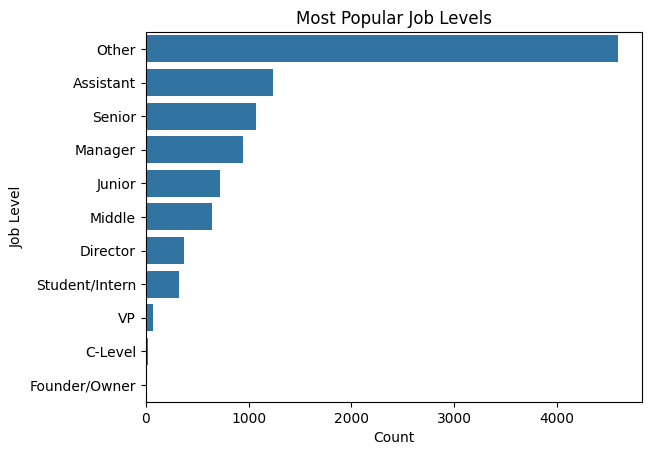

In [29]:
def map_job_level(level):
    if level in label_qwen_map:
        return label_qwen_map[level]
    if not (level in labels):
        return 'Other'
    return level

df['qwen_job_level_mapped'] = df['qwen_job_level'].apply(map_job_level)

top_categories = df.qwen_job_level_mapped.value_counts()
sns.barplot(y=top_categories.index, x=top_categories.values, orient='h')
plt.title('Most Popular Job Levels')
plt.xlabel('Count')
plt.ylabel('Job Level')

---
---
---

In [11]:
df.qwen_bert_job_level.value_counts()[:25]

,count
qwen_bert_job_level,
Other,4289
Assistant,1241
Senior,994
Manager,901
Junior,817
Middle,624
Director,355
Student/Intern,217
VP,74


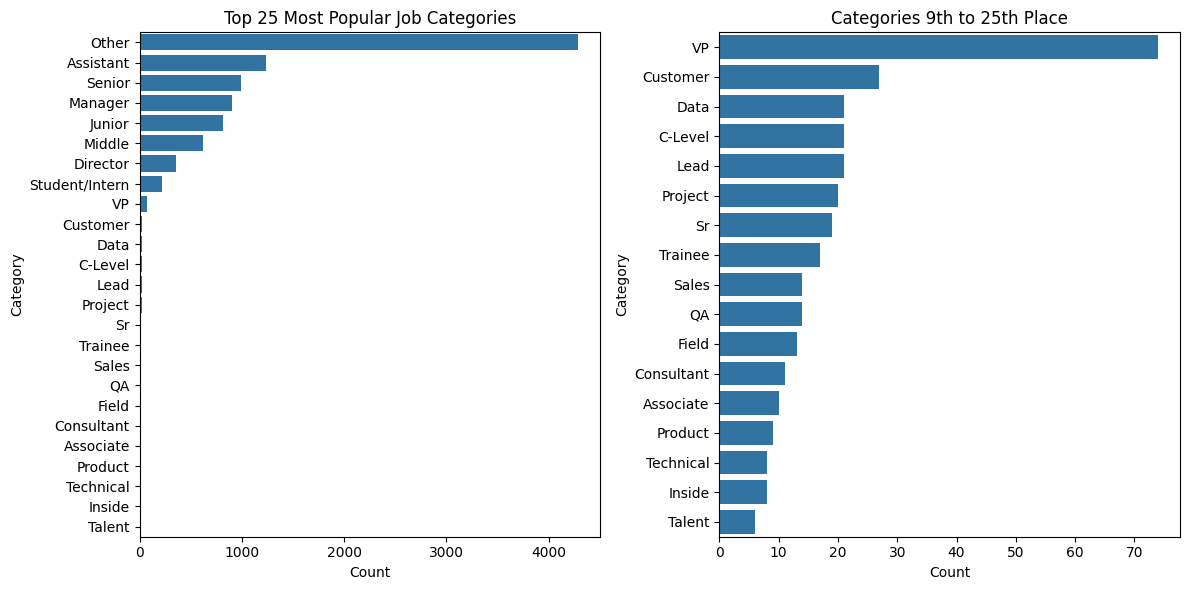

In [16]:
plt.figure(figsize=(12, 6))

# First subplot: Top 25 most popular categories
plt.subplot(1, 2, 1)
top_25_categories = df.qwen_bert_job_level.value_counts()[:25]
sns.barplot(y=top_25_categories.index, x=top_25_categories.values, orient='h')
plt.title('Top 25 Most Popular Job Categories')
plt.xlabel('Count')
plt.ylabel('Category')


# Second subplot: Categories from 9th to 25th place
plt.subplot(1, 2, 2)
categories_9_to_25 = df.qwen_bert_job_level.value_counts()[8:25]
sns.barplot(y=categories_9_to_25.index, x=categories_9_to_25.values, orient='h')
plt.title('Categories 9th to 25th Place')
plt.xlabel('Count')
plt.ylabel('Category')

plt.tight_layout()
plt.show()

mapping here for qwen_bert

In [75]:
labels

['Student/Intern',
 'Junior',
 'Assistant',
 'Middle',
 'Senior',
 'Manager',
 'Director',
 'VP',
 'C-Level',
 'Founder/Owner',
 'Other']

In [32]:
label_qwen_bert_map = {
    'Trainee': 'Student/Intern',
    'Lead': 'Senior',
    'Apprentice': 'Junior',
    'Intern': 'Student/Intern',
    'Sr.': 'Senior',
    'Sr': 'Senior'
}

Text(0, 0.5, 'Job Level')

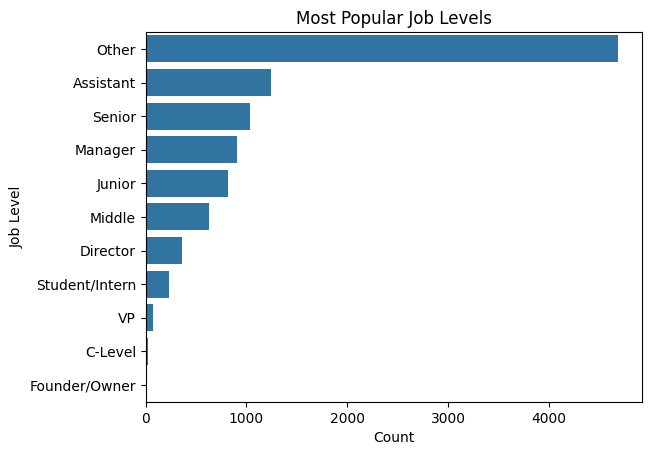

In [33]:
def map_job_level(level):
    if level in label_qwen_bert_map:
        return label_qwen_bert_map[level]
    if not (level in labels):
        return 'Other'
    return level

df['qwen_bert_job_level_mapped'] = df['qwen_bert_job_level'].apply(map_job_level)

top_categories = df.qwen_bert_job_level_mapped.value_counts()
sns.barplot(y=top_categories.index, x=top_categories.values, orient='h')
plt.title('Most Popular Job Levels')
plt.xlabel('Count')
plt.ylabel('Job Level')

---

And now we have two additional features that we can further use as coded features in our classifier or as weak labels for pre-train.

In [64]:
df[['qwen_job_level', 'qwen_bert_job_level']] = df[['qwen_job_level_mapped', 'qwen_bert_job_level_mapped']]

In [65]:
df = df.drop(['qwen_job_level_mapped', 'qwen_bert_job_level_mapped'], axis=1)

In [66]:
df.to_parquet('/content/drive/MyDrive/Data/cleaned_qwen_bert_levels.parquet')

### Get Ground Truth labels

We can use one of the most powerful models to get strong labels and call them our target variable. It transforms our task to classification problem.

Let's use Gemini model. It's smart enough to perfectly label our data.

In [47]:
import google.generativeai as genai
from google.colab import userdata
import os

os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')

genai.configure(api_key=os.environ["GOOGLE_API_KEY"])

In [54]:
gem_model = genai.GenerativeModel('gemini-2.0-flash')

We want to sample objects for our golden dataset. But we want all classes be there. So let's implement some weights.

As weights we will take inversed squared logarithm of class frequency, it will help us preserve smoothed class distribution but also it will increase chances for job levels like VP, C-Level and Founder/Owner

<Axes: ylabel='qwen_job_level'>

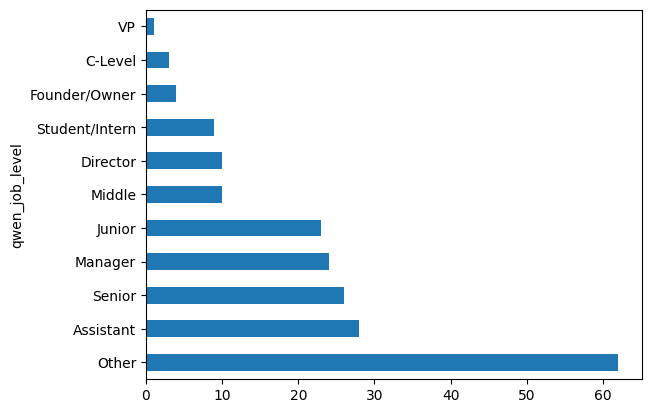

In [94]:
import pandas as pd
import math

df = pd.read_parquet('/content/drive/MyDrive/Data/cleaned_qwen_bert_levels.parquet')


weights = 1 / df['qwen_job_level'].value_counts().apply(lambda x: math.log(x) ** 2)
df['weights'] = df['qwen_job_level'].map(weights)

# Sample the DataFrame using the calculated weights
golden_df = df.sample(200, weights='weights',
                       random_state=19
                       )

golden_df.qwen_job_level.value_counts().plot(kind='barh')

#### First Gemini run

In [101]:
import time

labels = [
    "Student/Intern", "Junior Specialist", "Assistant", "Middle Specialist",
    "Senior Specialist", "Manager", "Director", "VP", "C-Level", "Founder/Owner",
    "Other"
]

def gemini_classify_job_title(job_title):
    prompt = (
        "You are an expert job title classifier. "
        "Your task is to choose exactly one category from the following list: "
        f"{', '.join(labels)}.\n\n"
        "Classify the following job title, and reply with only one of the above labels!!!\n"
        f"Job title: {job_title}\n\n"
        f"If there is no explicit clue, answer 'Other'\n"
        f"Choose wisely. What category describes job title better? Answer:"
    )
    return gem_model.generate_content(prompt).text


for title in tqdm(golden_df.job_title.values):
    level = gemini_classify_job_title(title)
    golden_df.loc[golden_df.job_title == title, 'gemini_job_level'] = level
    time.sleep(4) # api limits

  0%|          | 0/200 [00:00<?, ?it/s]

In [102]:
golden_df.to_parquet('/content/drive/MyDrive/Data/golden_dataset.parquet')

<Axes: ylabel='gemini_job_level'>

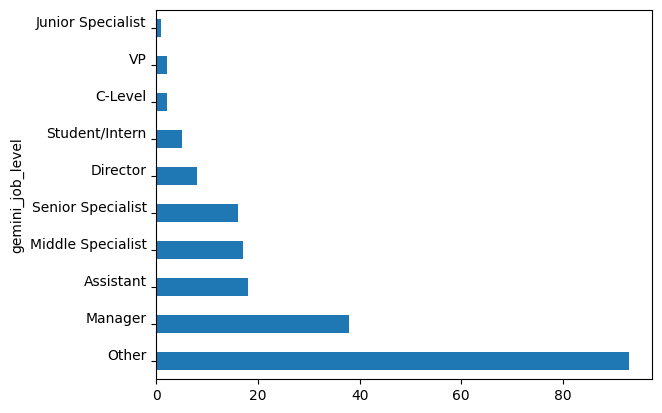

In [104]:
golden_df.gemini_job_level.value_counts().plot(kind='barh')

In [105]:
golden_df[golden_df.gemini_job_level.str.contains('Other')]

,job_title,bert_title,qwen_job_level,qwen_bert_job_level,weights,gemini_job_level
586914,Mainframe Tester,Mainframe Tester,Junior,Junior,0.023102,Other\n
260664,Civil Design Engineer,Civil Design Engineer,Junior,Junior,0.023102,Other\n
275573,PowerBITech Lead,PowerBITech Lead,Director,Director,0.028544,Other\n
290060,Traveling Esthetician,Travel Esthetician,Other,Other,0.014063,Other\n
271382,Looking for Java Full Stack Developer with Banking Domain Exp,Java Full Stack Developer,Junior,Junior,0.023102,Other\n
...,...,...,...,...,...,...
355918,Nuclear Pharmacist,Nuclear Pharmacist,Other,Other,0.014063,Other\n
1295346,Associate Quantity Surveyor (PQS),Associate Quantity Surveyor,Assistant,Assistant,0.019701,Other\n
710739,Payroll Administrator (Recruitment Company),Payroll Administrator,Other,Assistant,0.014063,Other\n
715929,Volunteer: Email Layout &amp; Template for UIA Australia,,Other,Other,0.014063,Other\n


It looks like "Other" class took a lot of labels from "Middle Specialist". I didn't expect it from Gemini.

#### Second Gemini run

Let's remove Other class.

In [ ]:
import time

labels = [
    "Student/Intern", "Junior Specialist", "Assistant", "Middle Specialist",
    "Senior Specialist", "Manager", "Director", "VP", "C-Level", "Founder/Owner",
    # "Other"
]

def gemini_classify_job_title(job_title):
    prompt = (
        "You are an expert job title classifier. "
        "Your task is to choose exactly one category from the following list: "
        f"{', '.join(labels)}.\n\n"
        "Classify the following job title, and reply with only one of the above labels!!!\n"
        f"Job title: {job_title}\n\n"
        # f"If there is no explicit clue, answer 'Other'\n"
        f"Choose wisely. What category describes job title better? Answer:"
    )
    return gem_model.generate_content(prompt).text


for title in tqdm(golden_df.job_title.values):
    level = gemini_classify_job_title(title)
    golden_df.loc[golden_df.job_title == title, 'gemini_job_level_2'] = level.strip()
    time.sleep(3.5) # api limits

  0%|          | 0/200 [00:00<?, ?it/s]